### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

GlobalAttrTitle GlobalAttrSource
0                                  MERRA-2 Global CDH         GES DISC
1                                 MERRA-2 Global PBLH         GES DISC
2                                 MERRA-2 Global TLML         GES DISC
3   MODIS Terra AOD 550 Dark Target Deep Blue Comb...         Giovanni
4   MODIS Terra Aerosol Optical Depth Land Ocean Mean         Giovanni
24         Sentinel-5P TROPOMI Methane CH4 California         GES DISC
25  Sentinel-5P TROPOMI Carbon Monoxide CO California         GES DISC
26    Sentinel-5P TROPOMI Tropospheric NO2 California         GES DISC
27         Sentinel-5P TROPOMI Total Ozone California         GES DISC
28  Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...         GES DISC

### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

provider      project
0                      AirNow  air_quality
1                      AirNow        AQACF
2          GRIMM-Aethalometer        AQACF
3                   PurpleAir        AQACF
4                     QuantAQ     AQIC-Raw
5                     QuantAQ         AQIC
6                     QuantAQ  AQIC-Hourly
7           PurpleAir-GMU-Cal  air_quality
8  PurpleAir-GMU-Intermediate  air_quality
9    PurpleAir-GMU-Raw-Hourly  air_quality

In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

index   platform               platform_short_name        lat  \
0         0  000010102                        St. John's  47.652800   
1         1  000010401                       Mount Pearl  47.505000   
2         2  000010501               Grand Falls Windsor  49.019400   
3         3  000010601                         Goose Bay  53.304700   
4         4  000010602  MacPherson Avenue - Corner Brook  48.952240   
...     ...        ...                               ...        ...   
3471   7059  TT1010003                         Inchelium  48.296960   
3472   7060  TT5420500              Santa Rosa Rancheria  36.233333   
3473   7062  TT9209004                             Miami  36.922222   
3474   7064  UB1010001                       Ulaanbaatar  47.928385   
3475   7066  UZB010001                          Tashkent  41.367200   

             lon          min_datetime          max_datetime  
0     -52.816700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
1     -52.794700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
2     -55.802800  2018-01-01T00:00:00Z  2021-03-31T00:00:00Z  
3     -60.364400  2018-01-02T00:00:00Z  2024-03-31T00:00:00Z  
4     -57.922070  2020-01-01T00:00:00Z  2022-02-28T00:00:00Z  
...          ...                   ...                   ...  
3471 -118.202420  2018-01-09T00:00:00Z  2019-05-31T00:00:00Z  
3472 -119.765083  2018-01-01T00:00:00Z  2023-08-24T00:00:00Z  
3473  -94.838890  2018-01-01T00:00:00Z  2024-03-31T00:00:00Z  
3474  106.929470  2018-01-01T00:00:00Z  2024-03-31T00:00:00Z  
3475   69.272500  2019-04-01T00:00:00Z  2024-03-31T00:00:00Z  

[3476 rows x 7 columns]

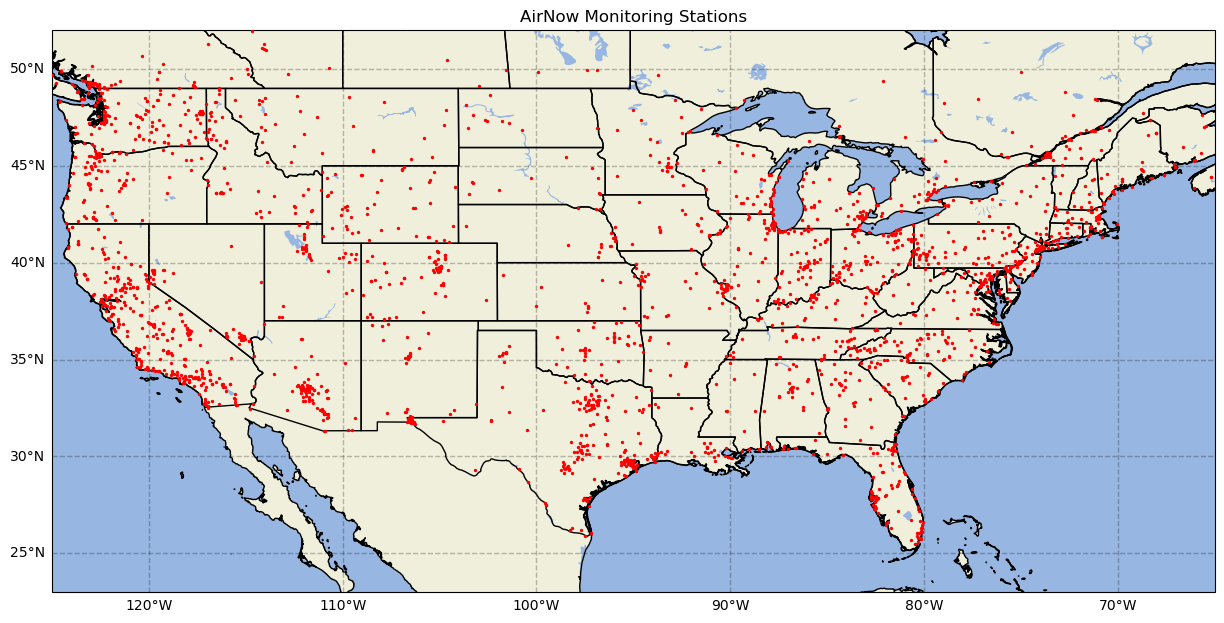

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# Dixie Fire

The 2021 California wildfire season was one of the worst on record with 2,569,386 million acres burned. The 2021 CA wildfire season produces hundreds of fires including the Dixie fire that, at nearly a million acres burned, is the largest single source fire in state history. 
It's estimated that California wildfires emitted 75 million metric tons of carbon dioxide in just three months (June - August 2021).

75 million metric tons of carbon dioxide is equal to:
- 16,310,993 passenger cars driven for a year (Greenhouse Gas - GHG)
- 188,489,840,317 miles driven by an average passenger vehicle (GHG)
- 8,439,293,350 gallons of gasoline consumed (Carbon Dioxide Emissions – CO2)
- 82,896,993 pounds of coal burned (CO2)
- 173,640,855 barrels of oil consumed (CO2)

Relevant Articles:
- https://www.nytimes.com/2021/09/21/climate/wildfire-emissions-climate-change.html 
- https://www.theguardian.com/us-news/2021/dec/25/what-the-numbers-tells-us-about-a-catastrophic-year-of-wildfires 

### Area of Interest

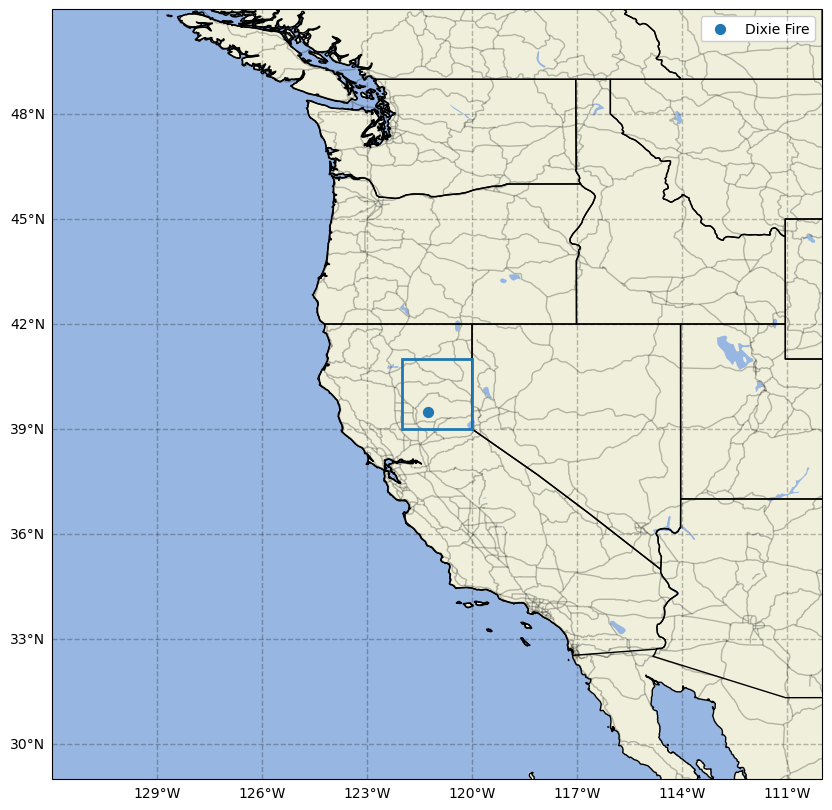

In [8]:
wildfires_bb = {'min_lon': -122, 'max_lon': -120, 'min_lat': 39, 'max_lat': 41}
dixie_start = datetime(2021,7,1)
dixie_end = datetime(2021,10,1)

plotting.map_box(wildfires_bb, [(39.4908, -121.2508, 'Dixie Fire')], padding=10)

### Dixie Fire Aerosol Index Visualization via GIBS

In [9]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'OMPS_Aerosol_Index',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2021, 7, 13)
edate = datetime(2021, 8, 20)
dates = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

print(f'Obtaining {len(dates)} days of imagery from GIBS...')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    gibs_wms_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'
    params = {
        'service': 'WMS',
        'version': '1.3.0',
        'request': 'GetMap',
        'layers': ','.join(layers),
        'styles': '',
        'srs': 'epsg:4326',  # Map projection
        'crs': 'epsg:4326',
        'bbox':','.join(['30','-128','50', '-110']),  # Bounds (min-lat, min-lon, max-lat, max-lon)
        'width': '500',
        'height': '500',
        'time':datatime,  # Time of data
        'format':'image/png',  # Image format
        'transparent':'TRUE',
        'exceptions': 'XML'
    }

    url = f'{gibs_wms_url}{"&".join([f"{k}={v}" for k,v in params.items()])}' 
    response = urlopen(url)
    image = I.open(response)
    draw = ImageDraw.Draw(image)
    draw.text((50, 12), f'Suomi NPP OMPS Aerosol Index  - {datatime}', fill='rgb(0,0,0)', font=font)
    frames.append(image)

Obtaining 38 days of imagery from GIBS...


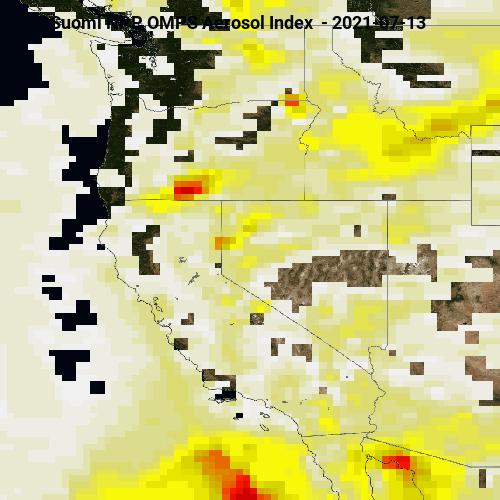

In [10]:
frames[0].save('OMPS_Aerosol_Index.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=500,
               loop=0)

Image('OMPS_Aerosol_Index.gif')

### Dixie Fire Smoke Plume Visualization
On August 8, 2021, the Moderate Resolution Imaging Spectroradiometer (MODIS) on NASA’s Aqua satellite captured this image of the Dixie Fire.

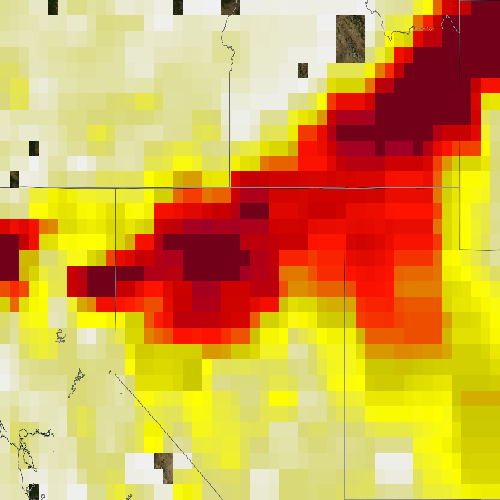

In [11]:
gibs_wms_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?'
params = {
    'service': 'WMS',
    'version': '1.3.0',
    'request': 'GetMap',
    'layers': ','.join(layers),
    'styles': '',
    'srs': 'epsg:4326',  # Map projection
    'crs': 'epsg:4326',
    'bbox':','.join(['37','-123','45', '-110']),  # Bounds (min-lat, min-lon, max-lat, max-lon)
    'width': '500',
    'height': '500',
    'time':'2021-08-08',  # Time of data
    'format':'image/png',  # Image format
    'transparent':'TRUE',
    'exceptions': 'XML'
}

url = f'{gibs_wms_url}{"&".join([f"{k}={v}" for k,v in params.items()])}' 
response = urlopen(url)
Image(response.read())

In [12]:
modis_subset_date = datetime(2021,8,8)
modis_dixie_subset = firealarm_processing.data_subsetting('MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean', {'min_lon': -125, 'max_lon': -100, 'min_lat': 30, 'max_lat': 50}, modis_subset_date, modis_subset_date, 'Aerosol Optical Depth')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=MYD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean&b=-125%2C30%2C-100%2C50&startTime=2021-08-08T00%3A00%3A00Z&endTime=2021-08-08T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.591198207999696 seconds


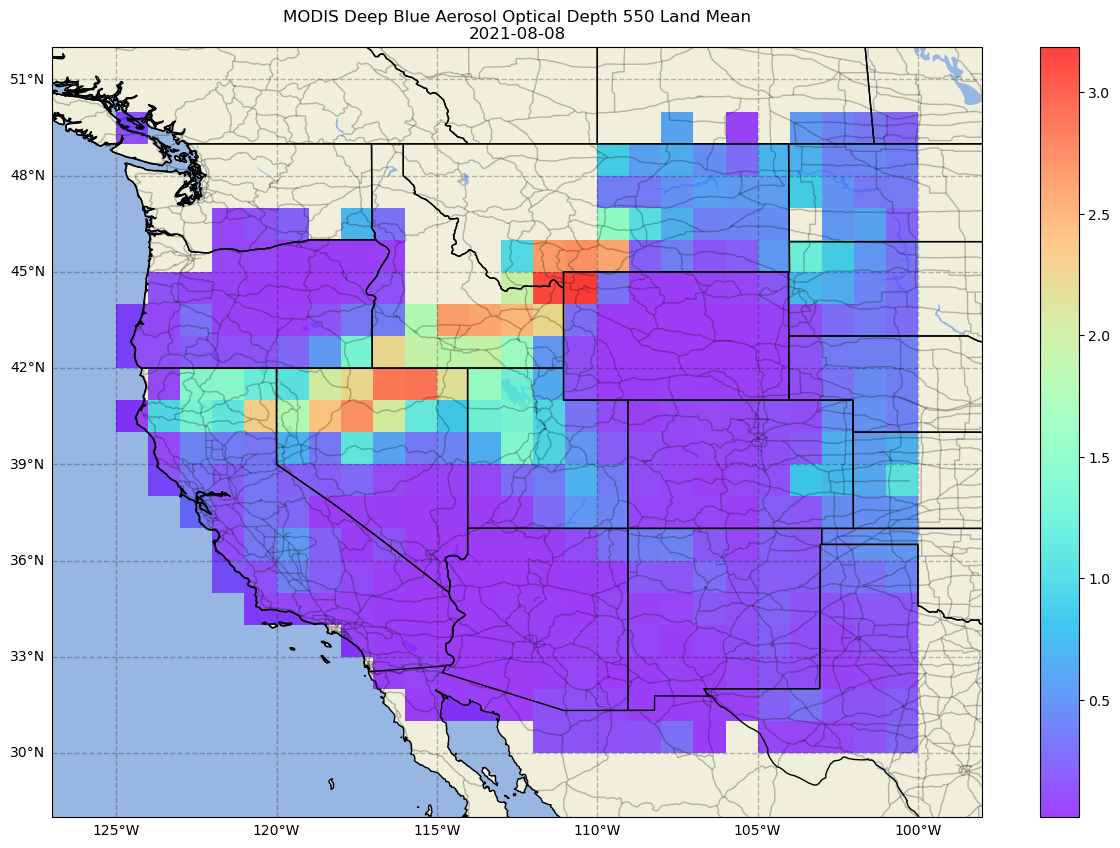

In [13]:
plotting.map_data(modis_dixie_subset[0], f'MODIS Deep Blue Aerosol Optical Depth 550 Land Mean\n{modis_subset_date.strftime("%Y-%m-%d")}')

#### AOD Longitude Hovmöller

In [14]:
wildfires_parameters = ('MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean', {'min_lon': -123, 'max_lon': -100, 'min_lat': 38, 'max_lat': 42}, datetime(2021,7,13), datetime(2021,9,20))
wildfires_lon_hov = firealarm_processing.hofmoeller(*wildfires_parameters, dim='longitude')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/longitudeTimeHofMoellerSpark?ds=MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean&b=-123%2C38%2C-100%2C42&startTime=2021-07-13T00%3A00%3A00Z&endTime=2021-09-20T00%3A00%3A00Z

Waiting for response from FireAlarm... took 12.90031212499889 seconds


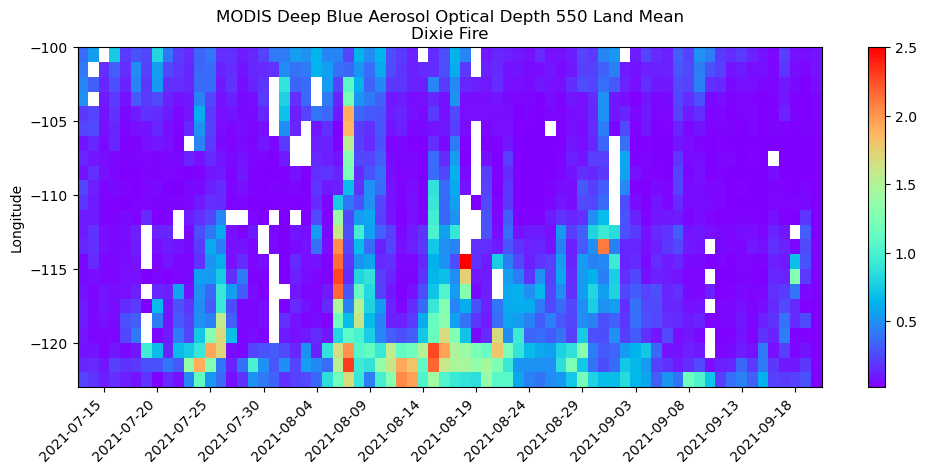

In [15]:
wildfires_hov_title = 'MODIS Deep Blue Aerosol Optical Depth 550 Land Mean\nDixie Fire'
plotting.heatmap(wildfires_lon_hov['mean'].transpose(), '', 'Longitude', wildfires_hov_title)

In [16]:
tropomi_co_dixie_map = firealarm_processing.temporal_mean('TROPOMI-0.1deg-CA-CO', wildfires_bb, dixie_start, dixie_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeAvgMapSpark?ds=TROPOMI-0.1deg-CA-CO&b=-122%2C39%2C-120%2C41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z

Waiting for response from FireAlarm... took 10.315292457999021 seconds


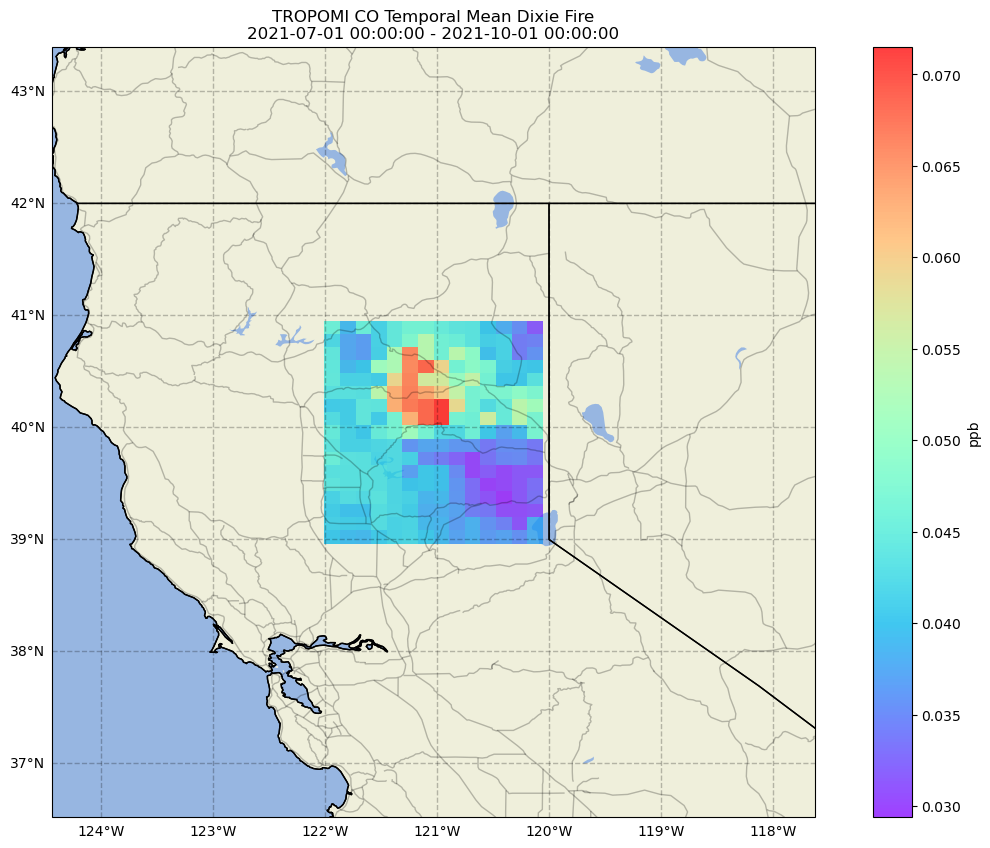

In [17]:
plotting.map_data(tropomi_co_dixie_map, f"TROPOMI CO Temporal Mean Dixie Fire\n{dixie_start} - {dixie_end}", cb_label='ppb')

In [18]:
tropomi_co_dixie_ts =  firealarm_processing.spatial_timeseries('TROPOMI-0.1deg-CA-CO', wildfires_bb, dixie_start, dixie_end)
tropomi_no2_dixie_ts =  firealarm_processing.spatial_timeseries('TROPOMI_NO2_global', wildfires_bb, dixie_start, dixie_end)
tropomi_o3_dixie_ts =  firealarm_processing.spatial_timeseries('TROPOMI_O3_global', wildfires_bb, dixie_start, dixie_end)
tropomi_ch4_dixie_ts =  firealarm_processing.spatial_timeseries('TROPOMI_CH4_global', wildfires_bb, dixie_start, dixie_end)
tropomi_so2_dixie_ts =  firealarm_processing.spatial_timeseries('TROPOMI_SO2_global', wildfires_bb, dixie_start, dixie_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CO&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.9205115000004298 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_NO2_global&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.23903108300146414 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_O3_global&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.22846791700067115 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CH4_global&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=20

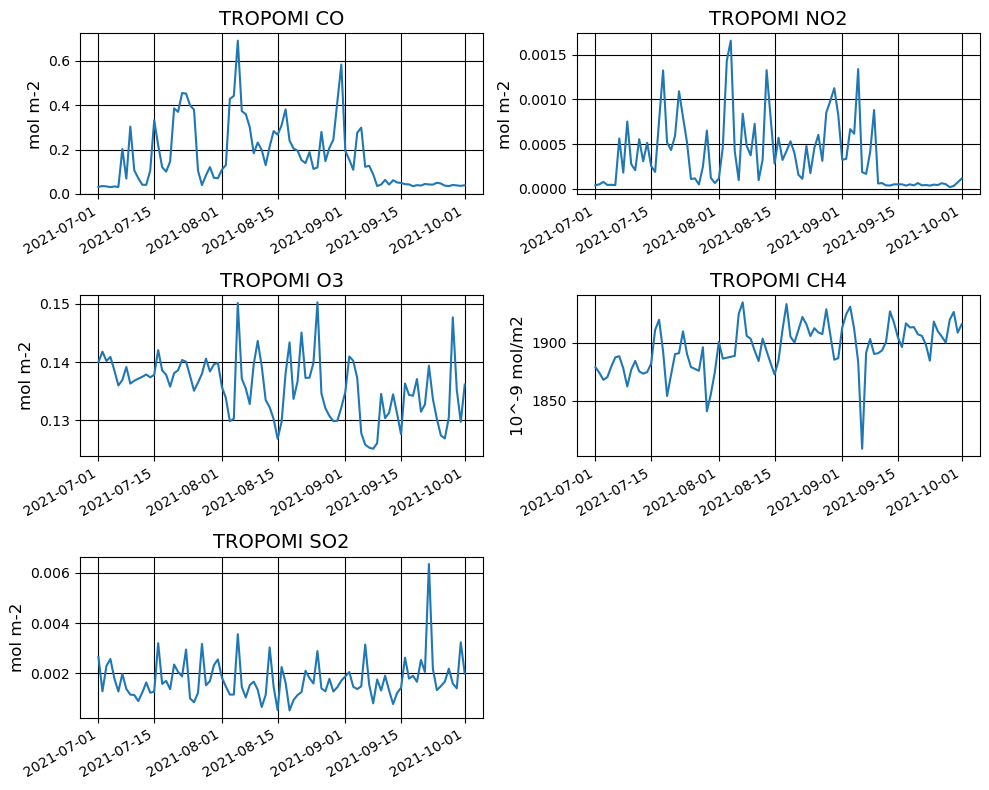

In [19]:
plotting.timeseries_multi_plot([(tropomi_co_dixie_ts['maximum'], 'TROPOMI CO', 'mol m-2'), (tropomi_no2_dixie_ts['maximum'], 'TROPOMI NO2', 'mol m-2'), (tropomi_o3_dixie_ts['maximum'], 'TROPOMI O3', 'mol m-2'), (tropomi_ch4_dixie_ts['maximum'], 'TROPOMI CH4', '10^-9 mol/m2'), (tropomi_so2_dixie_ts['maximum'], 'TROPOMI SO2', 'mol m-2')])

In [20]:
viirs_aot_dixie_ts =  firealarm_processing.spatial_timeseries('laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean', wildfires_bb, dixie_start, dixie_end)
modis_aod_dixie_ts = firealarm_processing.spatial_timeseries('MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean', wildfires_bb, dixie_start, dixie_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.44820133300163434 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=MOD08_D3_6_1_Deep_Blue_Aerosol_Optical_Depth_550_Land_Mean&minLon=-122&minLat=39&maxLon=-120&maxLat=41&startTime=2021-07-01T00%3A00%3A00Z&endTime=2021-10-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.49727370899927337 seconds


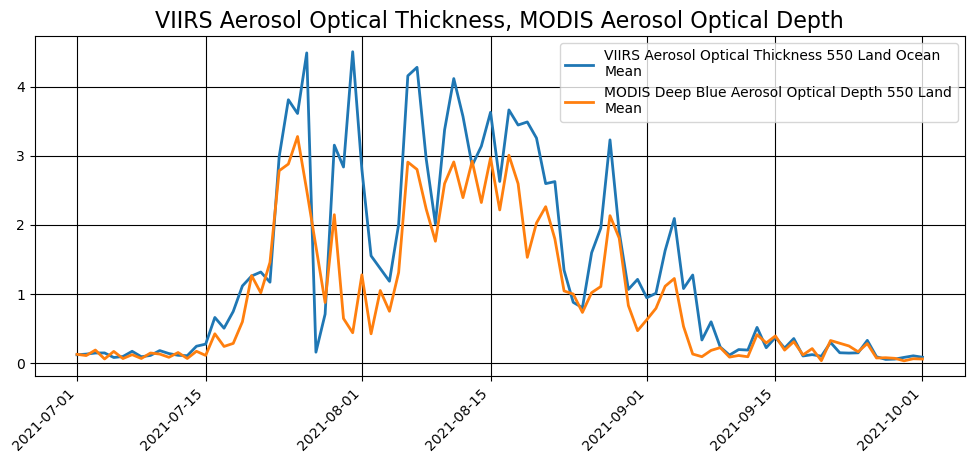

In [21]:
plotting.timeseries_plot([(viirs_aot_dixie_ts['maximum'], 'VIIRS Aerosol Optical Thickness 550 Land Ocean Mean'), (modis_aod_dixie_ts['maximum'], 'MODIS Deep Blue Aerosol Optical Depth 550 Land Mean')], '', '', 'VIIRS Aerosol Optical Thickness, MODIS Aerosol Optical Depth', norm=False)

## Dixie Fire In-situ Sites

In [22]:
dixie_airnow_sites = airnow_sites[airnow_sites['platform_short_name'].isin(['Quincy BAM', 'Anderson', 'Yreka'])]
dixie_airnow_sites_formatted = [(site['lat'], site['lon'], site['platform_short_name'])for i, site in dixie_airnow_sites.iterrows()]

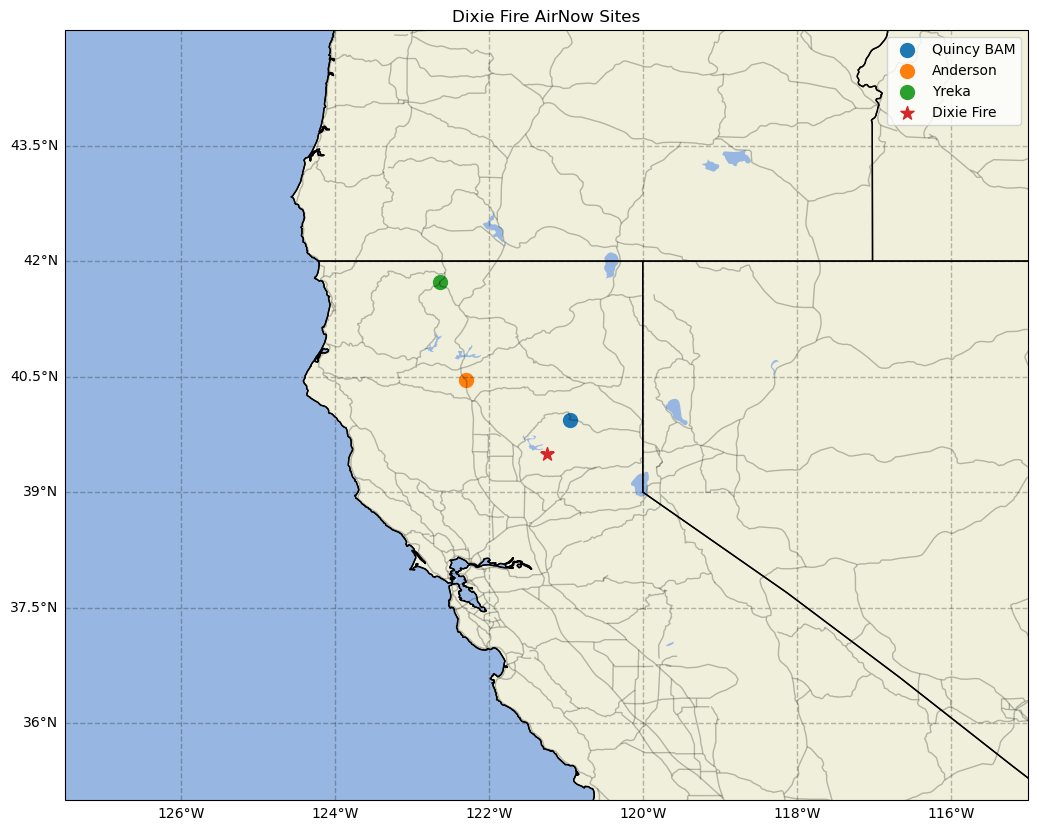

In [23]:
plotting.map_points(dixie_airnow_sites_formatted + [(39.4908, -121.2508, 'Dixie Fire')], region='norcal', title='Dixie Fire AirNow Sites')

In [24]:
dixie_insitu = firealarm_processing.insitu('AirNow', 'AQACF', '-122,39,-120,40.5', datetime(2021,7,21), datetime(2021,8,1))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=AirNow&project=AQACF&startTime=2021-07-21T00:00:00Z&endTime=2021-08-01T00:00:00Z&bbox=-122,39,-120,40.5


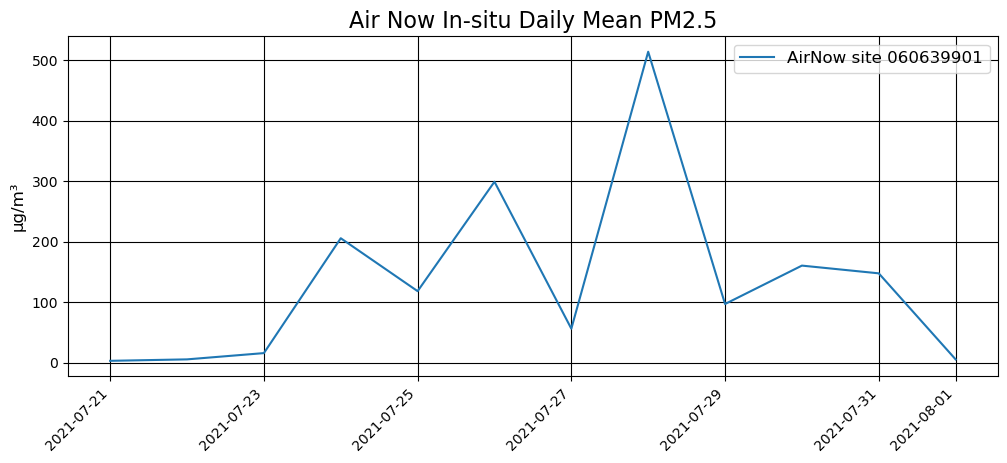

In [25]:
plotting.plot_insitu([(dixie_insitu[dixie_insitu['platform_id'] == '060639901'], 'pm2_5', 'AirNow site 060639901')], 'Air Now In-situ Daily Mean PM2.5', 'µg/m³')